In [1]:
# !pip install folium scikit-learn scipy

In [2]:
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance
%matplotlib inline

# L'épidémie de choléra à Londres en 1854

Cette étude porte sur la construction d'une **carte épidémiologique** afin de mieux comprendre l'épidémie de choléra dans le quartier de Soho à Londres en 1854. Par l'analyse des données, nous cherchons à trouver le **centre de l'épidémie** et prouver sa proximité avec l'une des pompes d'une quartier.

## Chargement et aperçu des données

In [3]:
data_death = pd.read_csv("deaths.csv")
data_pumps = pd.read_csv("pumps.csv")
data_death_pumps = pd.read_csv("deaths_and_pumps.csv")

In [4]:
print("""
Death dataset columns : {}
Pumps dataset columns : {}
Death/Pumps dataset columns : {}
""".format(list(data_death.columns), list(data_pumps.columns), list(data_death_pumps.columns)))


Death dataset columns : ['Death', 'X coordinate', 'Y coordinate']
Pumps dataset columns : ['Pump Name', 'X coordinate', 'Y coordinate']
Death/Pumps dataset columns : ['Number of deaths', 'X coordinate', 'Y coordinate']



On renomme les colonnes pour éviter les typos à cause des majuscules et des espaces.

In [5]:
death_cols = {
    list(data_death.columns)[0]: 'd_count',
    list(data_death.columns)[1]: 'x', 
    list(data_death.columns)[2]: 'y'}
pump_cols = {
    list(data_pumps.columns)[0]: 'name',
    list(data_pumps.columns)[1]: 'x', 
    list(data_pumps.columns)[2]: 'y'}
d_p_cols = {
    list(data_death_pumps.columns)[0]: 'death_per_pumps',
    list(data_death_pumps.columns)[1]: 'x', 
    list(data_death_pumps.columns)[2]: 'y'}

data_death.rename(columns=death_cols, inplace=True)
data_pumps.rename(columns=pump_cols, inplace=True)
data_death_pumps.rename(columns=d_p_cols, inplace=True)

Un petit regard sur la donnée.

In [6]:
print(data_death.head())
print('\n')
print(data_pumps.head())
print('\n')
print(data_death_pumps.head())

   d_count          x         y
0        1  51.513418 -0.137930
1        1  51.513418 -0.137930
2        1  51.513418 -0.137930
3        1  51.513361 -0.137883
4        1  51.513361 -0.137883


             name          x         y
0       Broad St.  51.513341 -0.136668
1    Crown Chapel  51.513876 -0.139586
2  Gt Marlborough  51.514906 -0.139671
3        Dean St.  51.512354 -0.131630
4         So Soho  51.512139 -0.133594


   death_per_pumps          x         y
0                3  51.513418 -0.137930
1                2  51.513361 -0.137883
2                1  51.513317 -0.137853
3                1  51.513262 -0.137812
4                4  51.513204 -0.137767


In [7]:
print("Donnée manquante dans le dataset death.csv : {}".format(len(data_death[data_death.isnull().any(axis=1)])))
print("Donnée manquante dans le dataset pumps.csv : {}".format(len(data_pumps[data_pumps.isnull().any(axis=1)])))
print("Donnée manquante dans le dataset death_and_pumps.csv : {}".format(len(data_death_pumps[data_death_pumps.isnull().any(axis=1)])))

Donnée manquante dans le dataset death.csv : 0
Donnée manquante dans le dataset pumps.csv : 0
Donnée manquante dans le dataset death_and_pumps.csv : 0


## Création de la carte

### Les décès

On commence par afficher les décès sur la carte en pointant vers une coordonnée disponible dans le dataset.

In [8]:
data_death_df = data_death.groupby(['x', 'y']).d_count.count().to_frame()
data_death_df.reset_index(inplace=True)
death_coordinates = data_death_df[["x","y"]]
death_coordinates = death_coordinates.values.tolist()

In [9]:
soho_c = death_coordinates[0]
death_map = folium.Map(location=soho_c, tiles='Stamen Toner', zoom_start=17)
for p in range(0, len(death_coordinates)):
    folium.CircleMarker(death_coordinates[p], radius=2*int(data_death_df['d_count'][p]), 
                        color='blue', fill=True, fill_color='blue',
                        opacity = 0.4).add_to(death_map)

In [10]:
death_map

### Les pompes

On y ajoute ensuite les emplacements de pompes.

In [11]:
pump_coordinates = data_pumps[["x","y"]]
pump_coordinates = pump_coordinates.values.tolist()

In [12]:
death_pump_map = death_map
for p in range(0, len(pump_coordinates)):
    folium.Marker(pump_coordinates[p],
                    popup='Name : {}'.format(data_pumps['name'][p]),
                    icon=folium.Icon(color='red', icon='info-sign')).add_to(death_pump_map)
death_pump_map

## Recherche de la pompe au centre de l'épidémie

Sur la carte précédente on voit très clairement par un cercle de diamètre supérieur aux autres, que la plus grande densité de décès se trouve au plus près de la pompe de Broad St. Essayons de le démontrer par l'analyse.<br>
On peut par exemple utiliser l'algorithme [K-means](https://fr.wikipedia.org/wiki/K-moyennes) pour former des **clusters** et vérifier quelle pompe se trouve au centre du cluster contenant le plus de cas. <br>
On commence par initialiser K-means avec un nombre de clusters correspondant au nombre de pompes.

In [13]:
n_pumps = len(data_pumps)

In [14]:
kmeans = KMeans(n_clusters = n_pumps, init ='k-means++')
kmeans.fit(data_death[data_death.columns[1:3]])
data_death['cluster_label'] = kmeans.fit_predict(data_death[data_death.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(data_death[data_death.columns[1:3]])

On observe la répartition des clusters.

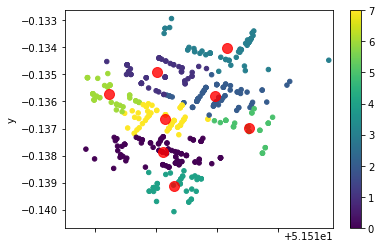

In [15]:
data_death.plot.scatter(x = 'x', y = 'y', c=labels, s=20, 
                        ylim=[data_pumps['y'].min()-0.001, data_pumps['y'].max()-0.001],
                        xlim=[data_pumps['x'].min()+0.0015, data_pumps['x'].max()+0.001], cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.8)
plt.show()

Ici on voit que le nombre de clusters est trop grand. Pour certains points, l'appartenance à un cluster plus qu'un autre n'apparaît pas clair. On voit d'ailleurs sur la carte que beaucoup de pompe sont à l'extérieur du centre de l'épidémie.
Il nous faut trouver le nombre optimal de cluster possible. Pour ça on utilise la méthode [Elbow Curve](https://en.wikipedia.org/wiki/Elbow_method_(clustering))

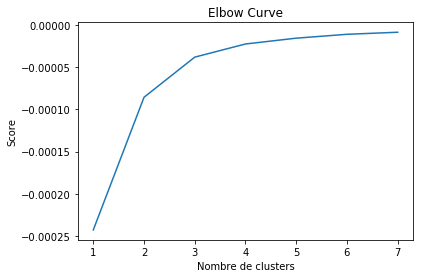

In [16]:
K_clusters = range(1, n_pumps)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = data_death[['x']]
X_axis = data_death[['y']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score)
plt.xlabel('Nombre de clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

La courbe nous montre que le nombre de **K** optimal est **3**.

In [17]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(data_death[data_death.columns[1:3]])
data_death['cluster_label'] = kmeans.fit_predict(data_death[data_death.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(data_death[data_death.columns[1:3]])

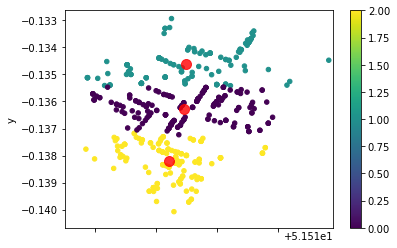

In [18]:
data_death.plot.scatter(x = 'x', y = 'y', c=labels, s=20, 
                        ylim=[data_pumps['y'].min()-0.001, data_pumps['y'].max()-0.001],
                        xlim=[data_pumps['x'].min()+0.0015, data_pumps['x'].max()+0.001], cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.8)
plt.show()

On récupère le cluster qui contient le plus de cas de décès.

In [19]:
cluster_by_death = data_death.groupby('cluster_label').count()['d_count']
max_cluster = cluster_by_death.idxmax()
print('Cluster avec le plus grand nombre de morts : {}'.format(max_cluster))

Cluster avec le plus grand nombre de morts : 0


In [20]:
cluster_by_death

cluster_label
0    202
1    137
2    150
Name: d_count, dtype: int64

On peut placer les clusters sur la map pour en avoir une meilleure représentation et vérifier que le cluster trouvé se trouve près de la pompe de Broad St.

In [21]:
cluster_map = death_pump_map
for p in range(0, len(centers)):
    folium.Marker(centers[p],
                    popup='Cluster : {}'.format(p),
                    icon=folium.Icon(color='green')).add_to(death_pump_map)
cluster_map

On vérifie notre hypothèse visuellement. On peut aussi calculer **la distance euclidienne** entre le cluster 0 et les pompes pour vérifier qu'il est au plus près de la pompe de Broad St.

In [22]:
c_0_coordinates = centers[max_cluster]

In [23]:
euclidean_distances = []
for i in pump_coordinates:
    euclidean_distances.append(distance.euclidean(i, c_0_coordinates))

L'indice de la distance minimale nous donne l'indice de la pompe au centre de l'épidémie.

In [24]:
pump_idx = euclidean_distances.index(min(euclidean_distances))

In [25]:
data_pumps.iloc[pump_idx]

name    Broad St.
x         51.5133
y       -0.136668
Name: 0, dtype: object

**On prouve donc par clustering que la pompe de Broad St. est au centre de l'épidémie.**